# Импорт необходимых библиотек

In [1]:
import os
import pickle
import collections
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, cross_val_score
from optuna.integration import CatBoostPruningCallback
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import plot_roc_curve, roc_auc_score, confusion_matrix

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 20)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings("ignore")

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Загружаем и подготавливаем набор данных

In [2]:
train_df = pd.read_csv('train_mod.csv', index_col='match_id_hash')
test_df = pd.read_csv('test_mod.csv', index_col='match_id_hash')
train_df

game_time  radiant_tower_kills  \
match_id_hash                                                      
a400b8f29dece5f4d266f49f1ae2e98a        155                    0   
b9c57c450ce74a2af79c9ce96fac144d        658                    2   
6db558535151ea18ca70a6892197db41         21                    0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576                    0   
b1b35ff97723d9b7ade1c9c3cf48f770        453                    0   
...                                     ...                  ...   
defd0caeed6ea83d7d5fbdec013fe7d1       1783                    3   
bc7a87ed5f9c2bca55f9f7a93da0b0c5        377                    0   
e2ca68ac1a6847f4a37f6c9c8ee8695b        643                    0   
47ad6454ede66c1c78fdaa9391dfc556       2405                    6   
9928dfde50efcbdb2055da23dcdbc101       1775                    3   

                                  dire_tower_kills  radiant_barrack_kills  \
match_id_hash                                                               
a400b8f29dece5f4d266f49f1ae2e98a                 0                      0   
b9c57c450ce74a2af79c9ce96fac144d                 0                      0   
6db558535151ea18ca70a6892197db41                 0                      0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 0                      0   
b1b35ff97723d9b7ade1c9c3cf48f770                 0                      0   
...                                            ...                    ...   
defd0caeed6ea83d7d5fbdec013fe7d1                 4                      0   
bc7a87ed5f9c2bca55f9f7a93da0b0c5                 0                      0   
e2ca68ac1a6847f4a37f6c9c8ee8695b                 0                      0   
47ad6454ede66c1c78fdaa9391dfc556                 3                      0   
9928dfde50efcbdb2055da23dcdbc101                 6                      0   

                                  dire_barrack_kills  radiant_aegis  \
match_id_hash                                                         
a400b8f29dece5f4d266f49f1ae2e98a                   0              0   
b9c57c450ce74a2af79c9ce96fac144d                   0              0   
6db558535151ea18ca70a6892197db41                   0              0   
46a0ddce8f7ed2a8d9bd5edcbb925682                   0              0   
b1b35ff97723d9b7ade1c9c3cf48f770                   0              0   
...                                              ...            ...   
defd0caeed6ea83d7d5fbdec013fe7d1                   0              0   
bc7a87ed5f9c2bca55f9f7a93da0b0c5                   0              0   
e2ca68ac1a6847f4a37f6c9c8ee8695b                   0              0   
47ad6454ede66c1c78fdaa9391dfc556                   0              1   
9928dfde50efcbdb2055da23dcdbc101                   0              0   

                                  dire_aegis  radiant_chat  dire_chat  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a           0            11          0   
b9c57c450ce74a2af79c9ce96fac144d           0             8          2   
6db558535151ea18ca70a6892197db41           0             0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682           0             2          2   
b1b35ff97723d9b7ade1c9c3cf48f770           0             0          3   
...                                      ...           ...        ...   
defd0caeed6ea83d7d5fbdec013fe7d1           0             6         17   
bc7a87ed5f9c2bca55f9f7a93da0b0c5           0             0          0   
e2ca68ac1a6847f4a37f6c9c8ee8695b           0             9         14   
47ad6454ede66c1c78fdaa9391dfc556           0             2          2   
9928dfde50efcbdb2055da23dcdbc101           0             4          9   

                                  tower_kills_diff  barrack_kills_diff  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a                 0                   0   
b9c57c450ce74a2af79c9ce96fac144d                 2 

In [3]:
d = ['radiant_win', 'r_heroes_win_rate', 'd_heroes_win_rate', 'r_items_win_rate', 'd_items_win_rate', 'heroes_win_rate_ratio', 'items_win_rate_ratio']
#d = [c for c in train_df.columns if 'std' in c ]
#d.insert(0, 'radiant_win')
df_ = train_df[list(train_df.columns)[0:50]].copy()
corr = df_.corr()
corr.style.background_gradient(cmap='coolwarm')

,game_time,radiant_tower_kills,dire_tower_kills,radiant_barrack_kills,dire_barrack_kills,radiant_aegis,dire_aegis,radiant_chat,dire_chat,tower_kills_diff,barrack_kills_diff,aegis_diff,chat_diff,r_total_obs_placed,d_total_obs_placed,r_mean_obs_placed,d_mean_obs_placed,r_std_obs_placed,d_std_obs_placed,total_obs_placed_ratio,std_obs_placed_ratio,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,r_mean_sen_placed,d_mean_sen_placed,r_std_sen_placed,d_std_sen_placed,total_sen_placed_ratio,std_sen_placed_ratio,mean_sen_placed_ratio,r_total_creeps_stacked,d_total_creeps_stacked,r_mean_creeps_stacked,d_mean_creeps_stacked,r_std_creeps_stacked,d_std_creeps_stacked,total_creeps_stacked_ratio,std_creeps_stacked_ratio,mean_creeps_stacked_ratio,r_total_camps_stacked,d_total_camps_stacked,r_mean_camps_stacked,d_mean_camps_stacked,r_std_camps_stacked,d_std_camps_stacked,total_camps_stacked_ratio,std_camps_stacked_ratio,mean_camps_stacked_ratio,r_total_rune_pickups
game_time,1.000000,0.780006,0.778863,0.406105,0.414538,0.472045,0.461979,0.253760,0.263609,0.018428,-0.002112,0.013932,-0.000981,0.847522,0.844983,0.847522,0.844983,0.816261,0.815624,0.084485,0.147150,0.114287,0.643216,0.640490,0.643216,0.640490,0.638058,0.636752,0.259218,0.324291,0.288784,0.289260,0.319208,0.289260,0.319208,0.261082,0.282943,0.123614,0.169990,0.179142,0.369665,0.401371,0.369665,0.401371,0.347479,0.367868,0.230605,0.282415,0.256225,0.886541
radiant_tower_kills,0.780006,1.000000,0.478265,0.643841,0.197832,0.520292,0.267423,0.200306,0.228661,0.527073,0.331538,0.186681,-0.025093,0.671965,0.642376,0.671965,0.642376,0.654763,0.619823,0.091259,0.144167,0.111156,0.486631,0.521294,0.486631,0.521294,0.490422,0.514206,0.181692,0.239114,0.206343,0.225800,0.219866,0.225800,0.219866,0.198669,0.190701,0.101494,0.134384,0.147793,0.291726,0.287626,0.291726,0.287626,0.267870,0.259898,0.188717,0.222516,0.208873,0.807427
dire_tower_kills,0.778863,0.478265,1.000000,0.192509,0.651928,0.289274,0.525506,0.235366,0.219625,-0.494244,-0.333004,-0.163231,0.028486,0.641503,0.667330,0.641503,0.667330,0.620509,0.659362,0.040091,0.060899,0.045025,0.529240,0.487349,0.529240,0.487349,0.519323,0.492385,0.231792,0.272285,0.247524,0.189346,0.241487,0.189346,0.241487,0.167689,0.211087,0.056470,0.094938,0.102764,0.248855,0.301882,0.248855,0.301882,0.229944,0.270391,0.133694,0.180715,0.161965,0.558843
radiant_barrack_kills,0.406105,0.643841,0.192509,1.000000,0.071907,0.428114,0.117896,0.119015,0.138993,0.451037,0.686517,0.225992,-0.018609,0.346003,0.319788,0.346003,0.319788,0.344169,0.310662,0.050330,0.081478,0.062958,0.261838,0.309012,0.261838,0.309012,0.269145,0.302758,0.068530,0.102545,0.085056,0.097424,0.090034,0.097424,0.090034,0.084505,0.076435,0.039249,0.054269,0.062469,0.126029,0.120210,0.126029,0.120210,0.113990,0.105639,0.079114,0.094911,0.092922,0.451500
dire_barrack_kills,0.414538,0.197832,0.651928,0.071907,1.000000,0.135947,0.427220,0.154385,0.132894,-0.435019,-0.675867,-0.204442,0.031880,0.332100,0.352770,0.332100,0.352770,0.325330,0.355812,0.015354,0.015082,0.010498,0.327901,0.276080,0.327901,0.276080,0.317571,0.281003,0.138605,0.153568,0.144349,0.085192,0.109930,0.085192,0.109930,0.074453,0.093959,0.022666,0.041198,0.044097,0.110614,0.133775,0.110614,0.133775,0.100728,0.114167,0.053364,0.076884,0.067293,0.242689
radiant_aegis,0.472045,0.520292,0.289274,0.428114,0.135947,1.000000,0.024291,0.112777,0.126407,0.235103,0.217243,0.705806,-0.011370,0.428332,0.419870,0.428332,0.419870,0.424956,0.405959,0.014845,0.049914,0.031587,0.350029,0.393769,0.350029,0.393769,0.357589,0.384415,0.084330,0.124205,0.105720,0.133611,0.136165,0.133611,0.136165,0.113190,0.113699,0.044279,0.062754,0.073688,0.173702,0.178136,0.173702,0.178136,0.153143,0.153168,0.092987,0.115444,0.111740,0.498721
dire_aegis,0.461979,0.267423,0.525506,0.117896,0.427220,0.024291,1.000000,0.124625,0.108073,-0.243800,-0.224326,-0.691051,0.024793,0.406296,0.420701,0.406296,0.420701,0.394182,0.411651,0.009900,0.019454,0.012869,0

In [4]:
train_x = train_df.drop('radiant_win', axis=1)
train_y = train_df['radiant_win'].values

# Создаём и обучаем модель CatBoostClassifier

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, stratify=train_y, random_state=42)

In [19]:
pool_full = Pool(train_x, train_y)
pool_train = Pool(X_train, y_train)
pool_test = Pool(X_test)
pool_eval = Pool(X_test, y_test)

In [7]:
params = {
        'loss_function': 'Logloss',
        'custom_metric': 'AUC:hints=skip_train~false',
        'eval_metric': 'AUC',
        'od_wait': 30,
        'iterations': 1800,
        'learning_rate': 0.04411878615964169,
        'l2_leaf_reg': 6.668697599275072e-08,
        'bootstrap_type': 'MVS',
        'random_strength': 1,
        'depth': 5,
        'grow_policy': 'SymmetricTree',
        'od_type': 'IncToDec',
        'max_bin': 67,
        'boosting_type': 'Plain',
        'od_pval': 0.002282366393685342,
        
}

In [8]:
params = {"iterations": 1000,
          "depth": 2,
          "loss_function": "Logloss",
          "verbose": False,
          'eval_metric': 'AUC',
          'custom_metric': 'AUC:hints=skip_train~false',
          'learning_rate': 0.02, 
          'l2_leaf_reg': 1,
         }

scores = cv(pool_full, params, fold_count=5, plot=True)
scores['test-AUC-mean'].mean()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8453624198
bestIteration = 997

Training on fold [1/5]

bestTest = 0.8529798338
bestIteration = 999

Training on fold [2/5]

bestTest = 0.8459992803
bestIteration = 999

Training on fold [3/5]

bestTest = 0.8478356648
bestIteration = 999

Training on fold [4/5]

bestTest = 0.8477050889
bestIteration = 999



0.841042981524916

In [24]:
cbt_clf = CatBoostClassifier(eval_metric='AUC',
                             custom_metric='AUC:hints=skip_train~false',
                             early_stopping_rounds=20,
                             #task_type='GPU',
                             #devices='0:1',
                             #bootstrap_type='Bernoulli',
                             #iterations=150,
                             learning_rate=0.02, 
                             #random_strength=9,
                             l2_leaf_reg=1,
                             depth=3,                         
                             #od_type='IncToDec',
                             #od_pval=0.005,
                            )
#cbt_clf = CatBoostClassifier(**params)

In [25]:
cbt_clf.fit(pool_train, eval_set=pool_eval, verbose=1, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7785942	test: 0.7768304	best: 0.7768304 (0)	total: 43.1ms	remaining: 43.1s
1:	learn: 0.7912414	test: 0.7902756	best: 0.7902756 (1)	total: 82.7ms	remaining: 41.3s
2:	learn: 0.7975325	test: 0.7989233	best: 0.7989233 (2)	total: 131ms	remaining: 43.5s
3:	learn: 0.8068384	test: 0.8072812	best: 0.8072812 (3)	total: 189ms	remaining: 47.1s
4:	learn: 0.8132898	test: 0.8141805	best: 0.8141805 (4)	total: 252ms	remaining: 50.2s
5:	learn: 0.8161717	test: 0.8162628	best: 0.8162628 (5)	total: 309ms	remaining: 51.1s
6:	learn: 0.8160046	test: 0.8163467	best: 0.8163467 (6)	total: 357ms	remaining: 50.6s
7:	learn: 0.8151683	test: 0.8157317	best: 0.8163467 (6)	total: 403ms	remaining: 50s
8:	learn: 0.8147394	test: 0.8158908	best: 0.8163467 (6)	total: 463ms	remaining: 50.9s
9:	learn: 0.8143303	test: 0.8157150	best: 0.8163467 (6)	total: 505ms	remaining: 50s
10:	learn: 0.8161135	test: 0.8177478	best: 0.8177478 (10)	total: 545ms	remaining: 49s
11:	learn: 0.8168100	test: 0.8184943	best: 0.8184943 (11

## Смотрим результаты

In [12]:
y_pred = cbt_clf.predict_proba(pool_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8464986864741859

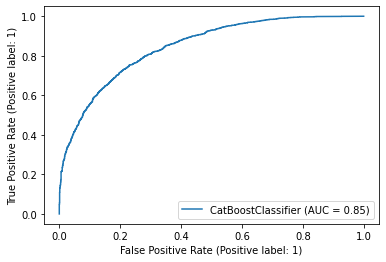

In [13]:
plot_roc_curve(cbt_clf, pool_test, y_test)

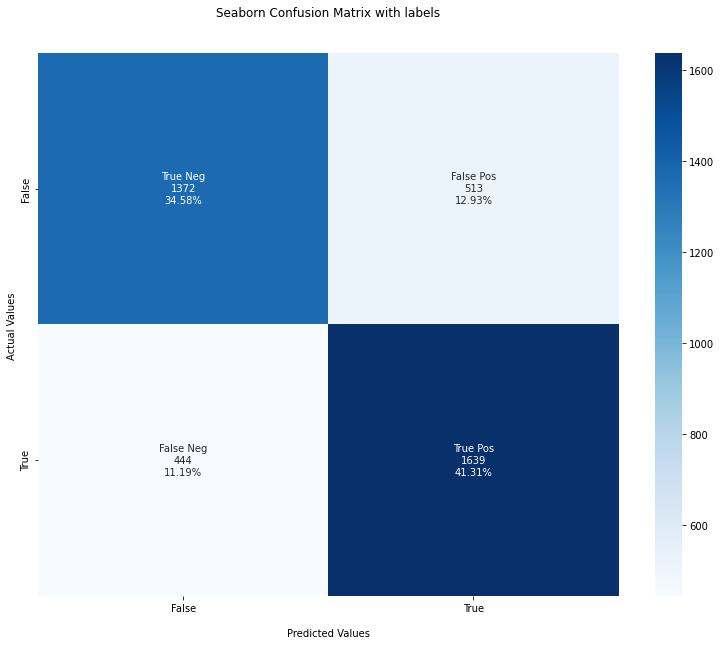

In [14]:
plt.figure(figsize=(13, 10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,cbt_clf.predict(pool_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Смотрим важность признаков

In [ ]:
features_importance = pd.DataFrame({'feature_importance': cbt_clf.get_feature_importance(pool_train), 'feature_names': X_train.columns}).sort_values(by=['feature_importance'], ascending=False)
for index, row in features_importance.iterrows():
    print('{0} : {1}'.format(row['feature_names'], row['feature_importance']))

## Optuna

# Делаем прогнозы для тестового набора

In [15]:
cbt_clf.fit(pool_full, verbose=1, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.049602
0:	learn: 0.8135972	total: 119ms	remaining: 1m 59s
1:	learn: 0.8241207	total: 231ms	remaining: 1m 55s
2:	learn: 0.8285037	total: 336ms	remaining: 1m 51s
3:	learn: 0.8299744	total: 445ms	remaining: 1m 50s
4:	learn: 0.8314929	total: 555ms	remaining: 1m 50s
5:	learn: 0.8332431	total: 669ms	remaining: 1m 50s
6:	learn: 0.8334699	total: 775ms	remaining: 1m 49s
7:	learn: 0.8337293	total: 883ms	remaining: 1m 49s
8:	learn: 0.8346632	total: 993ms	remaining: 1m 49s
9:	learn: 0.8350618	total: 1.1s	remaining: 1m 48s
10:	learn: 0.8357230	total: 1.21s	remaining: 1m 48s
11:	learn: 0.8367262	total: 1.32s	remaining: 1m 48s
12:	learn: 0.8369473	total: 1.43s	remaining: 1m 48s
13:	learn: 0.8373278	total: 1.53s	remaining: 1m 47s
14:	learn: 0.8374062	total: 1.64s	remaining: 1m 47s
15:	learn: 0.8378181	total: 1.75s	remaining: 1m 47s
16:	learn: 0.8380934	total: 1.85s	remaining: 1m 47s
17:	learn: 0.8387531	total: 1.95s	remaining: 1m 46s
18:	learn: 0.8390576	total: 2.05s	remaining: 

In [16]:
features_importance = pd.DataFrame({'feature_importance': cbt_clf.get_feature_importance(pool_full), 'feature_names': X_train.columns}).sort_values(by=['feature_importance'], ascending=False)
for index, row in features_importance.iterrows():
    print('{0} : {1}'.format(row['feature_names'], row['feature_importance']))

heroes_win_rate_ratio : 5.2663373681316665
mean_gold_ratio : 3.332782421805717
total_gold_ratio : 3.1028202955227075
barrack_kills_diff : 2.8267831356506496
items_win_rate_ratio : 2.5388476047237942
total_xp_ratio : 1.785329645561441
total_gpm_delta_ratio : 1.1241589422959848
radiant_barrack_kills : 1.0146719063721235
mean_level_ratio : 1.0009702232617343
mean_gpm_delta_ratio : 0.9494274077665736
tower_kills_diff : 0.9212249502736217
std_lh_ratio : 0.7215637703703374
mean_health_ratio : 0.6778361592084057
mean_xp_ratio : 0.6574974013819141
r_std_tower_damage : 0.6488628073412421
dire_barrack_kills : 0.6481208093919936
d_heroes_win_rate : 0.6245147464418519
total_gpm_max_ratio : 0.5873361682224278
total_health_ratio : 0.5549687354163667
std_item_uses_ratio : 0.5482986388366535
r_heroes_win_rate : 0.527588799441471
total_xppm_delta_ratio : 0.5025075504704797
r_std_y : 0.49576176554417345
d_hero_id=11 : 0.4826057789706833
total_purchases_ratio : 0.47567345497857894
mean_xppm_max_ratio : 0

In [26]:
test_pool = Pool(test_df)
y_test_pred = cbt_clf.predict(test_pool)
y_test_pred_proba = cbt_clf.predict_proba(test_pool)[:, 1]
df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred_proba}, index=test_df.index)

print('Соотношение классов: {}'.format(collections.Counter(y_test_pred)))
mn, mx = 0, 0
for el in y_test_pred_proba:
    if el < 0.5:
        mn += 1
    else:
        mx += 1
print('Количество проб меньше 50%: {0}\nКоличество проб больше 50%: {1}'.format(mn, mx))

Соотношение классов: Counter({1: 5378, 0: 4622})
Количество проб меньше 50%: 4622
Количество проб больше 50%: 5378


In [27]:
df_submission

,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.422679
70e5ba30f367cea48793b9003fab9d38,0.984988
4d9ef74d3a2025d79e9423105fd73d41,0.918263
2bb79e0c1eaac1608e5a09c8e0c6a555,0.872120
bec17f099b01d67edc82dfb5ce735a43,0.224213
...,...
9376a283b50779433de829c79529fe2c,0.008755
bce2bace8b61980d282c9f6a9c69ef9c,0.900035
dc00c2964363b0344a4891bdde235a44,0.325386


In [28]:
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2022-05-13_19-40-59.csv
